<a href="https://colab.research.google.com/github/TheFox272/MI201/blob/main/MI201_rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MI201 : Attaque de réseau de neurone parr ajout d'un bruit (ciblé ou non)

L'objectif de ce projet est de perturber un réseau de neurones, déjà entrainé et performant, en ajoutant un bruit très faible aux images qu'il prend en entrée.

## Introduction : données, évaluation et visualisation

On dispose d'une base de données de ms coco, comprenant une dizaine d'images. On va la charger à partir de notre répertoire github.

In [ ]:
!pip install wget  # librairie nécessaire pour la suite

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=fb6711b945ee4653e82801ada7ed955714bb662c0bdc25d344c194e847f97541
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget, os, zipfile
from io import BytesIO
import torch
import torchvision

# Chargement du zip du github, si data n'existe pas encore
if not os.path.isfile("data"):
  url = "https://github.com/TheFox272/MI201/raw/main/coco/coco.zip"
  archive_path = wget.download(url)
  dossier_extraction = "./data"
  os.makedirs(dossier_extraction, exist_ok=True)
  with zipfile.ZipFile(archive_path, 'r') as archive:
      archive.extractall(dossier_extraction)
  os.remove(archive_path)

os.chdir("./data")
im1 = torchvision.io.read_image("217730183_8f58409e7c_z.jpg").float() / 255
im2 = torchvision.io.read_image("541870527_8fe599ec04_z.jpg").float() / 255
im3 = torchvision.io.read_image("2124681469_7ee4868747_z.jpg", mode=torchvision.io.ImageReadMode.RGB).float() / 255
im4 = torchvision.io.read_image("2711568708_89f2308b85_z.jpg").float() / 255
im5 = torchvision.io.read_image("2928196999_acd5471d23_z.jpg").float() / 255
im6 = torchvision.io.read_image("3016145160_497da1b387_z.jpg").float() / 255
im7 = torchvision.io.read_image("4683642953_2eeda0820e_z.jpg").float() / 255
im8 = torchvision.io.read_image("6911037487_cc68a9d5a4_z.jpg").float() / 255
im9 = torchvision.io.read_image("8139728801_60c233660e_z.jpg").float() / 255
os.chdir("../")

im1 = torch.nn.functional.interpolate(im1.unsqueeze(0), size=520)[0]
im2 = torch.nn.functional.interpolate(im2.unsqueeze(0), size=520)[0]
im3 = torch.nn.functional.interpolate(im3.unsqueeze(0), size=520)[0]
im4 = torch.nn.functional.interpolate(im4.unsqueeze(0), size=520)[0]
im5 = torch.nn.functional.interpolate(im5.unsqueeze(0), size=520)[0]
im6 = torch.nn.functional.interpolate(im6.unsqueeze(0), size=520)[0]
im7 = torch.nn.functional.interpolate(im7.unsqueeze(0), size=520)[0]
im8 = torch.nn.functional.interpolate(im8.unsqueeze(0), size=520)[0]
im9 = torch.nn.functional.interpolate(im9.unsqueeze(0), size=520)[0]

images =  [im1, im2, im3, im4, im5, im6, im7, im8, im9]

x = torch.stack(images, dim=0)

On cherche à écrire une fonction permettant d'évaluer notre générateur de bruit. Il nous faut donc d'abord une fonction de score, qui prendra en entrée le bruit, la prédiction de notre modèle d'IA sur l'image d'origine, et sa prédiction sur l'image bruitée. Pour cela on va effectuer les calculs suivants :

\begin{align}
||\text{noise}||_2 &= \frac{||\text{noise}_R||_2 + ||\text{noise}_G||_2 + ||\text{noise}_B||_2}{3}\\
\text{score} &= ||z - z_{noise}||_2
\end{align}

In [ ]:
def score(noise, original_prediction, new_prediction, noise_factor=2000):
    noise_norm = torch.mean(torch.linalg.matrix_norm(noise))   # le bruit est une matrice 3*512*512 (R,G,B), on fait donc la moyenne des normes 2 sur chaque sous-matrice
    prediction_diff_norm = torch.linalg.matrix_norm((original_prediction - new_prediction).double())   # on calcul ici simplement la norme 2 de la différence
    return round(noise_norm.item(), 3), round(prediction_diff_norm.item(), 3)  # on arrondi les résultats

On va maintenant utiliser l'algorithme de segmentation disponible dans le catalogue torchvision afin de calculer, puis stocker, les prédictions sur les images originales.

In [ ]:
# Chargement du modèle
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)
net = net.cuda()

# Prédiction sur toutes les images
with torch.no_grad():
  x_transformed = (W.transforms())(x).cuda()
  z_original = net(x_transformed)["out"][:, [0, 8, 12, 15], :, :]
  _, z_original = z_original.max(1)

# Sauvegarde des résultats
torch.save(z_original, "data/z_original.t")



On peut maintenant coder la fonction d'évaluation du bruit et de visualisation des résultats. On affichera les images originales ainsi que leur prédictions, les images bruitées ainsi que leur prédictions, et le score et la norme du bruit.

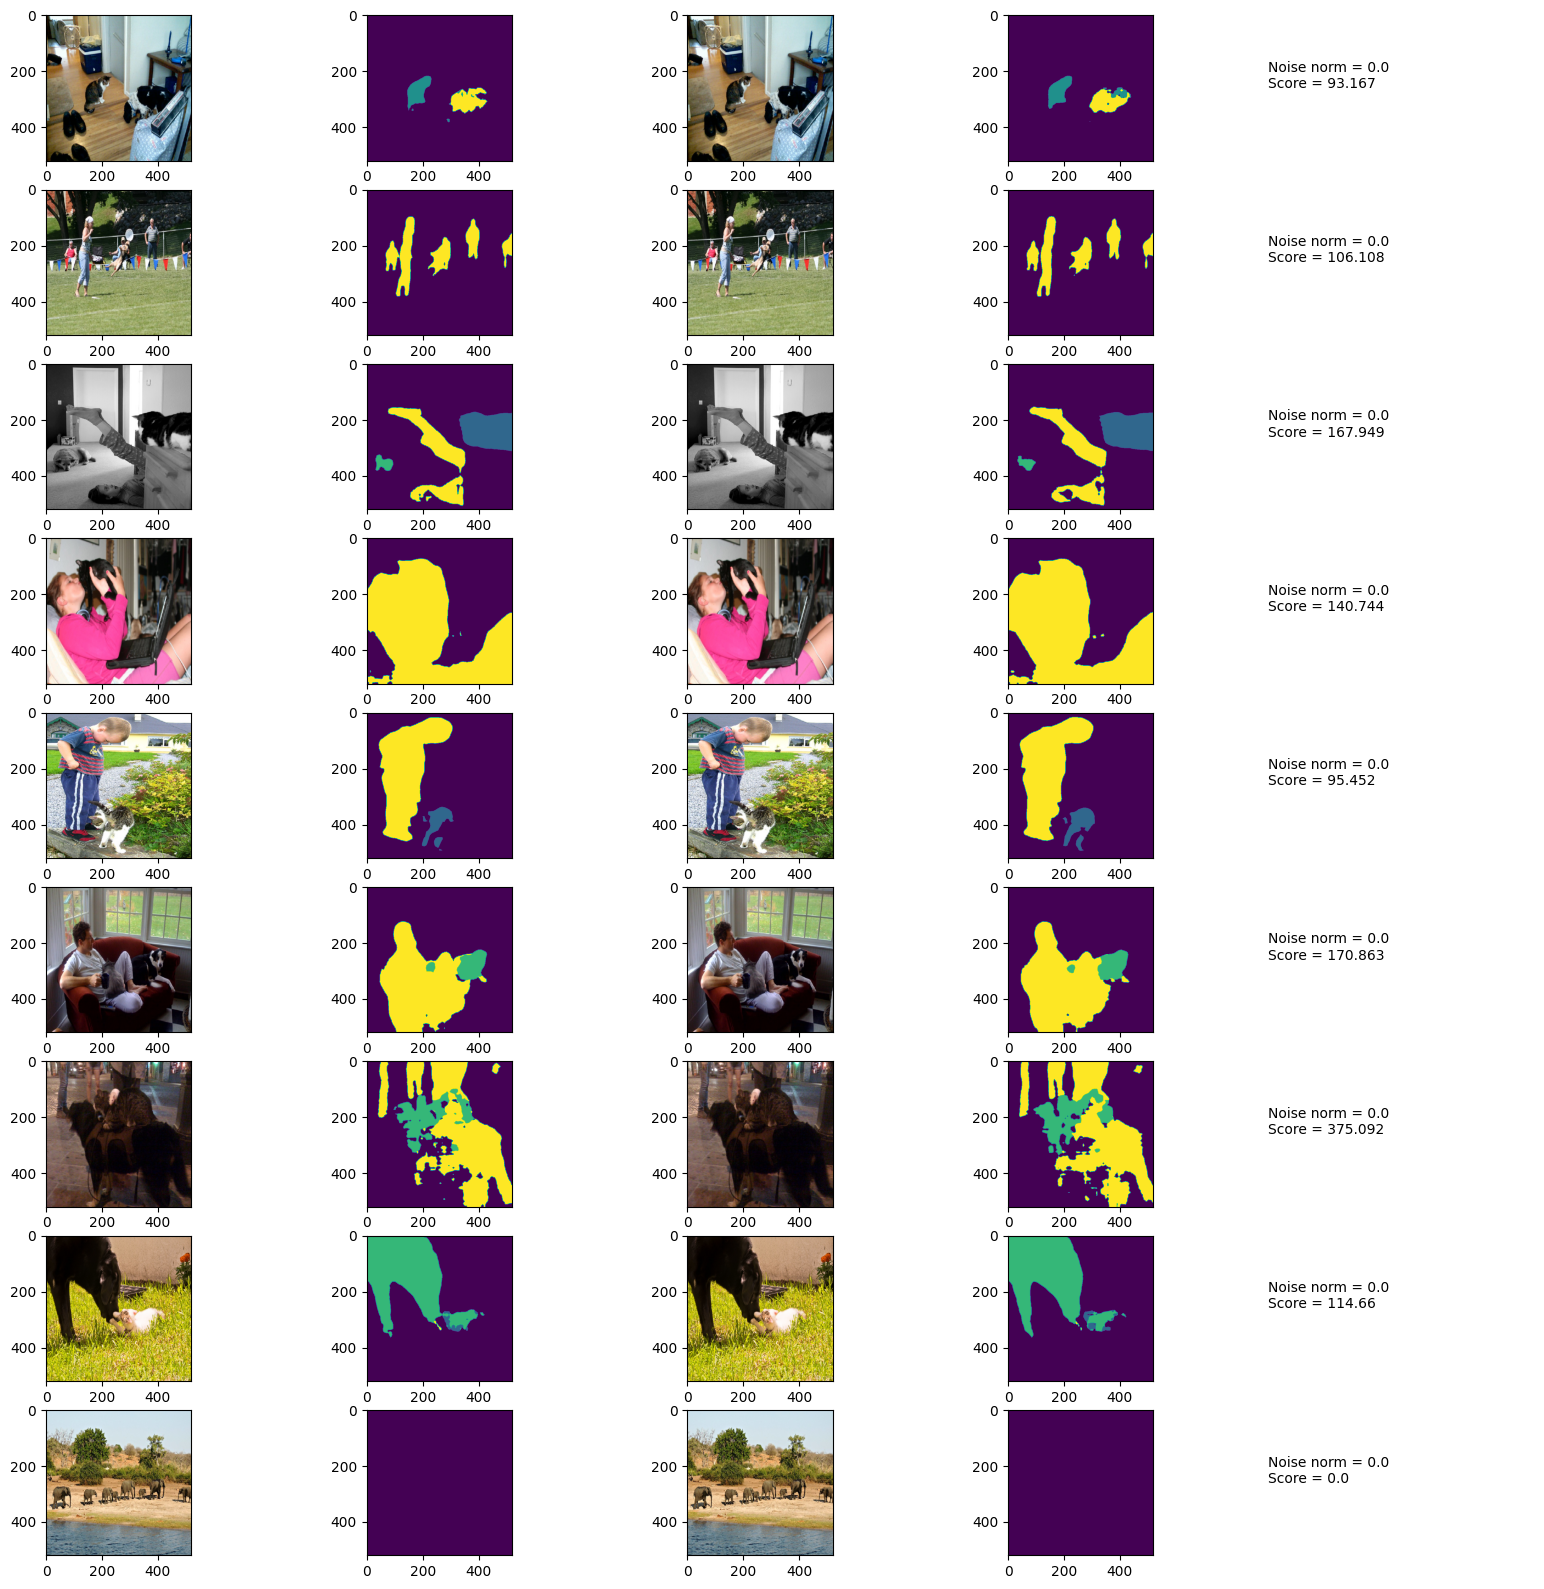

In [ ]:
import matplotlib.pyplot as plt  # utile pour l'affichage

def evaluator(noise_function):
  # Chargement des prédictions originales
  z_original = torch.load("data/z_original.t")

  # Application de la fonction de bruit sur les images
  images_noisy = [noise_function(image) for image in images]
  x_noisy = torch.stack(images_noisy, dim=0)

  # Prédiction sur toutes les images bruitées
  with torch.no_grad():
    x_noisy_transformed = (W.transforms())(x_noisy).cuda()
    z_noisy = net(x_noisy_transformed)["out"][:, [0, 8, 12, 15], :, :]
    _, z_noisy = z_noisy.max(1)

  # Affichage
  fig, axs = plt.subplots(9, 5, figsize=(20, 20))
  for i in range(9):
    # Transformation en numpy.array() pour l'affichage qui va suivre
    original_image = images[i].cpu().numpy().transpose(1, 2, 0)
    original_prediction = z_original[i].cpu().numpy()
    noise = x_noisy[i] - x[i]
    noisy_image = images_noisy[i].cpu().numpy().transpose(1, 2, 0)
    noisy_prediction = z_noisy[i].cpu().numpy()
    noise_norm, score_value = score(noise, z_original[i], z_noisy[i])

    # Affichage élément par élément
    axs[i, 0].imshow(original_image)
    axs[i, 1].imshow(original_prediction)
    axs[i, 2].imshow(noisy_image)
    axs[i, 3].imshow(noisy_prediction)
    axs[i, 4].axis('off')
    axs[i, 4].text(0, 0.5, f"Noise norm = {noise_norm}\nScore = {score_value}", fontsize=10)

  plt.show()

# test avec la fonction identité
evaluator(lambda image:image)

In [ ]:
max_noise = 4/255

def gaussian_noise(image):
    noise = torch.randn_like(image)
    noise *= max_noise / torch.mean(torch.linalg.matrix_norm(noise))
    return image + noise

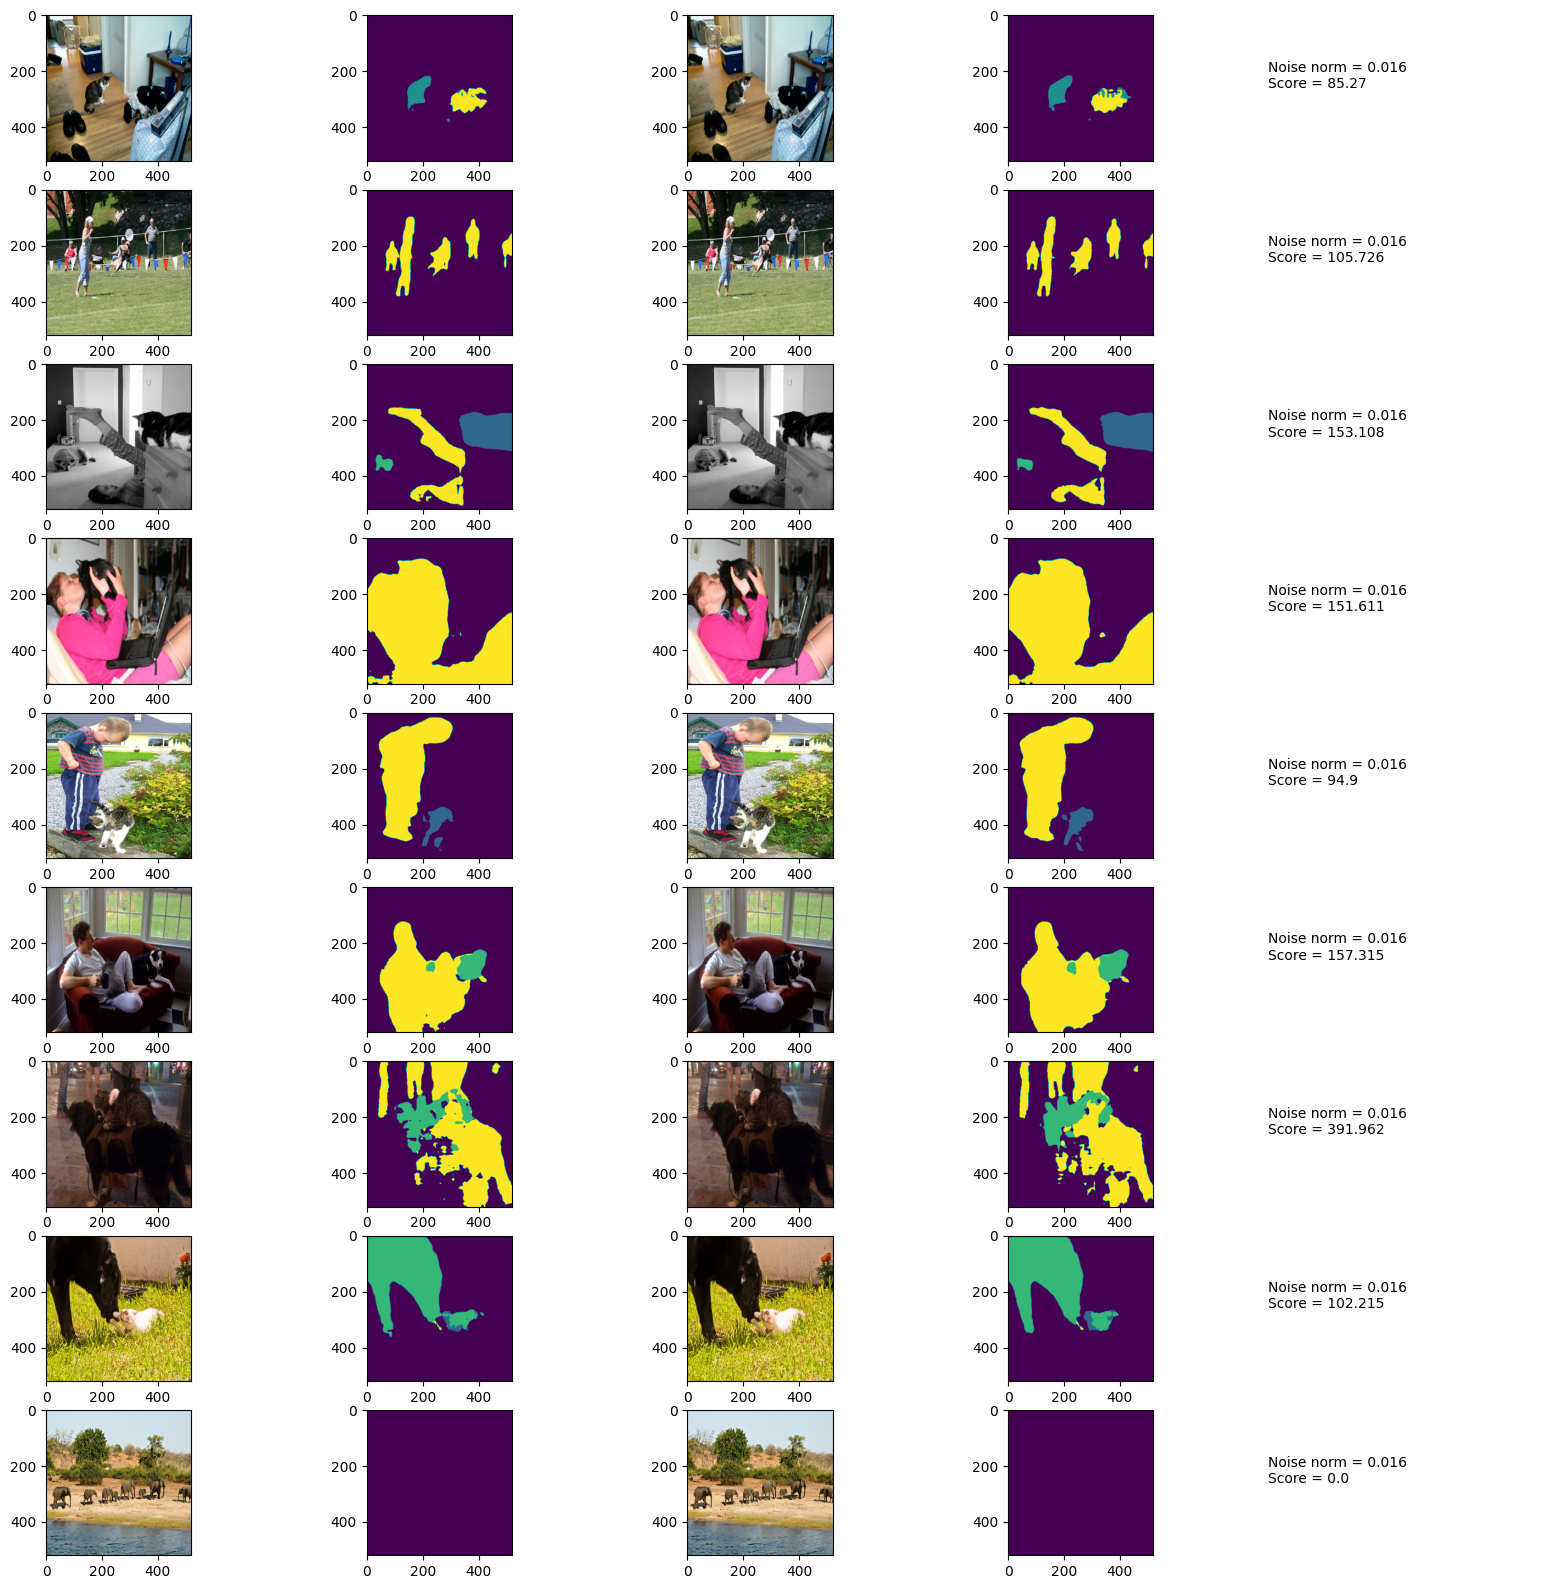

In [ ]:
evaluator(gaussian_noise)

## Attaque non ciblée - Fast Gradient Sign Method


 x : image d'origine,  
 y : le label de l'image,  
 θ : paramètres du modèle de segmentation,   
 J(θ,x,y) : la loss utilisée,   
 On calcule ∇xJ(θ,x,y) puis on ajuste l'image d'origine d'une petite perturbation dans la direction sign(∇xJ(θ,x,y)) qui maximise la loss. L'image modifiée résultante entraîne de mauvaise segmentation par le réseau.

In [ ]:
def loss(im1,im2):
    s=[]
    s.append(torch.mean(torch.linalg.matrix_norm((im1-im2).double())))
    return torch.stack(s,dim=0)

#Fast gradient sign method for untargeted attack
def generate_adversaries(net,baseImage, adv):
    delta = []
    adv = (W.transforms())(adv)
    #pour chaque image, on évalue la prédiction, dont on calcule la loss, puis on calcule le gradient de la loss par rapport à l'image et on update adv
    for j in range (9):
        net.eval()
        a = adv[j][None,:,:,:]
        a.requires_grad = True
        zm = net(a)["out"] # on prédit des cartes de score de confiance
        # print("zm = ",zm)
        with torch.no_grad():
            zm = zm[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
            # print("zm = ",zm,zm.shape)
            zm = zm.amax(1)
        # print("zm = ",zm,zm.shape)

        # print(zm.shape, zf[j][None,:,:].shape)
        # print("zm = ",zm)
        norm_loss = torch.negative(loss(zf[j], zm))
        print("loss = ",norm_loss)

        norm_loss.requires_grad = True
        norm_loss.mean().backward(retain_graph=True)
        data_grad = norm_loss.grad
        print(data_grad)
        print("data_grad = ",data_grad.sign())
        print("delta = ", EPS*data_grad.sign())
        print("adv = ", j,adv[j].shape, baseImage[j].shape, EPS*data_grad.sign())
        adv[j] = baseImage[j] + EPS*data_grad.sign()
        delta.append(EPS*data_grad.sign())
        norm_loss.grad.zero_()

    return delta


In [ ]:
# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
print("[INFO] creating adversarial example...")

# define the epsilon
EPS = 0.1
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
baseImage = (W.transforms())(x)
zf = net(baseImage)["out"] # on prédit des cartes de score de confiance pour le calcul de la loss dans generate_adversaries
_,zf = zf.max(1)
noise = torch.randn_like(baseImage)*EPS
adv = baseImage + noise #on inititialise les adversaires avec du bruit
delta = generate_adversaries(net, baseImage, adv) # delta est la perturbation à appliquer à chaque image

# Visualisation d'une image avec bruit
# print(noise.shape,noise)
# plt.imshow((im1 + noise[0]+delta[0]).numpy().transpose(1,2,0))
# plt.show()

net.train()

## Visualisation
with torch.no_grad():
  adversaries = (W.transforms())(adv)
  zm = net(adversaries)["out"] # on prédit des cartes de score de confiance pour les adversaires
  zm = zm[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
  _,zm = zm.max(1) # on prend le meilleur score

  x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
  x = (W.transforms())(x)
  z = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
  z = z[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
  _,z = z.max(1) # on prend le meilleur score


In [ ]:
couleur = torch.zeros(9,3,520,520)
couleur[:,0,:,:] = (z==1).float() # red for cat
couleur[:,1,:,:] = (z==2).float() # green for dog
couleur[:,2,:,:] = (z==3).float() # blue for person
visu = torch.cat([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=-1)
visubis = torch.cat([couleur[i] for i in range(9)],dim=-1).cpu()

im = [im1,im2,im3,im4,im5,im6,im7,im8,im9]
couleurm = torch.zeros(9,3,520,520)
couleurm[:,0,:,:] = (zm==1).float() # red for cat
couleurm[:,1,:,:] = (zm==2).float() # green for dog
couleurm[:,2,:,:] = (zm==3).float() # blue for person
visum = torch.cat([im[i] +noise[i] + delta[i] for i in range(9)],dim=-1).cpu()
visubism = torch.cat([couleurm[i] for i in range(9)],dim=-1).cpu()

visu = torch.cat([visu,visubis,visum,visubism],dim=1)
visu = visu.cpu().numpy().transpose(1,2,0)
dpi = plt.rcParams['figure.dpi']
width_px = 1600
height_px = 400
plt.figure(figsize=(width_px/dpi, height_px/dpi))
plt.imshow(visu)
plt.axis('off')
plt.show()

# Résultats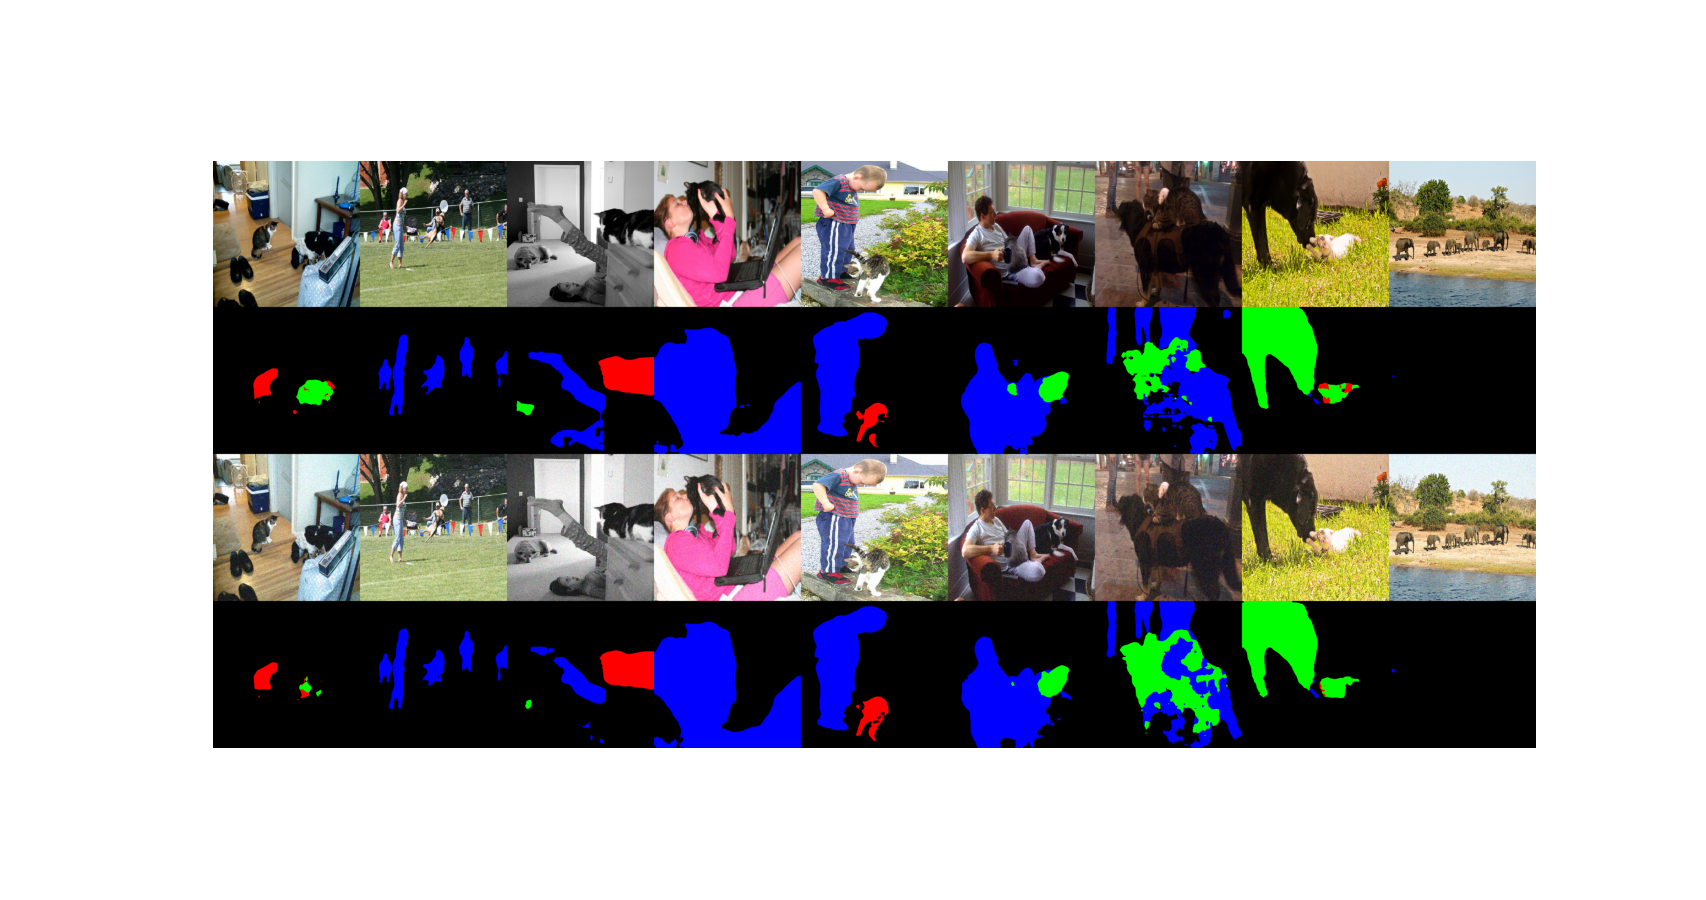
On observe que le chien de la première photo a disparu, l'humain et le chien de la photo 3 ont commencé a disparaître.  
Par contre, on n'observe aucun effet sur les humains photos 2, 4 et 5.

## Attaque ciblée